## Import packages

In [1]:
import matplotlib.pyplot as plt
import torch
import copy
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm 
from pathlib import Path
from ChromoGen import Conformations
from ChromoGen.data_utils import HiCDataset, HiCMap
from ChromoGen.model.Diffuser.training_utils import ConfigDataset
plt.style.use('../support/plot_style.txt')

2024-11-27 12:25:22.480323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Basic settings

In [2]:
# Directories containing the genome-wide conformations for each cell type
cgen_gm_conf_dir = '../../downloaded_data/conformations/ChromoGen/genome_wide/GM12878/'
cgen_imr_conf_dir = '../../downloaded_data/conformations/ChromoGen/genome_wide/IMR90/'

# Resolution of the generated data, number of genomic bins/monomers in each
resolution = 20_000
num_bins = 64

# Parameters used while generating data
guidance_params = [ # (cond_scale, rescaled_phi)
    (1.,0.),
    (5.,8.)
]

# Paths to the mcool files
gm_mcool = '../../outside_data/hic/GM12878_hg19.mcool'
imr_mcool = '../../outside_data/hic/IMR90_hg19.mcool'

# Path to the formatted Dip-C data and whether to compute it
formatted_dipc_fp = '../../downloaded_data/conformations/DipC/processed_data.h5'
compute_dipc = True

# Where to save data generated in this script
temp_data_dir = './temp_data/'
pdf_dir = './pdfs/'

# Parameters to use when inferring Hi-C probabilities from generated conformations
r_c = 1.5 
sigma = 3.72
decay_rate = 3.45

# Whether to use the GPU, double-precision
use_gpu = True and torch.cuda.is_available()
high_precision = True

# Maximum threads to use during computation. Particularly helps with file IO
max_workers = 8#None

#### Format them/initialize relevant objects

In [3]:
cgen_gm_conf_dir = Path(cgen_gm_conf_dir)
cgen_imr_conf_dir = Path(cgen_imr_conf_dir)

temp_data_dir = Path(temp_data_dir)
temp_data_dir.mkdir(exist_ok=True,parents=True)

pdf_dir = Path(pdf_dir)
pdf_dir.mkdir(exist_ok=True,parents=True)

gm_hic = HiCDataset(gm_mcool, resolution=resolution)
imr_hic = HiCDataset(imr_mcool, resolution=resolution)

if compute_dipc:
    config_ds = ConfigDataset(
        formatted_dipc_fp,
        segment_length=num_bins,
        remove_diagonal=False,
        batch_size=0,
        normalize_distances=False,
        geos=None,
        organisms=None,
        cell_types=None,
        cell_numbers=None,
        chroms=None,
        replicates=None,
        shuffle=False,
        allow_overlap=True,
        two_channels=False,
        try_GPU=True,
        mean_dist_fp=None,
        mean_sq_dist_fp=None,
    )
else:
    config_ds = None

dtype = torch.double if high_precision else torch.float
device = torch.device('cuda:0') if use_gpu else torch.device('cpu')

## Analyze

#### Support

In [4]:
def parse_filename(f):
    chrom = f.parent.name.split('_')[-1]
    start_idx = int(f.name.split('_')[2]) * 1000
    return chrom, start_idx

In [5]:
def load_region(
    f,
    hic_dataset,
    config_ds,
    guidance_params,
    resolution,
    compute_dipc,
    device=device,
    dtype=dtype
):

    # Get region details
    chrom, start_idx = parse_filename(f)

    # Load generated data
    cgen_confs = []
    d = f.parent
    for cs,rp in guidance_params:
        cgen_confs.append(
            Conformations(
                d/f'start_idx_{start_idx//1000}_cond_scale_{float(cs)}_rescaled_phi_{float(rp)}.pt',
                drop_invalid_conformations=True
            )
        )
    cgen_confs = cgen_confs[0].extend(cgen_confs[1:]).to_(dtype=dtype,device=device)

    # Load Hi-C data
    stop_idx = start_idx + cgen_confs.num_beads * resolution
    exp_hic = hic_dataset.fetch(chrom,start_idx,stop_idx).to_(dtype=dtype,device=device)
    # Normalize to nearest-neighbor probabilities, though this shouldn't actually affect any PCC results
    exp_hic.normalize_()

    # Load Dip-C data
    if compute_dipc:
        dipc_confs = Conformations(config_ds.fetch_specific_coords(chrom,start_idx)[-1]).to_(dtype=dtype,device=device)
    else:
        dipc_confs = None

    return cgen_confs, exp_hic, dipc_confs

In [6]:
def pcc(a,b):

    # Combine data
    v = torch.stack([a.squeeze(),b.squeeze()],dim=0)

    # Drop any NaN values. Especially important when Hi-C data contains zero-probability values
    v = v[:,v.isfinite().all(0)]

    # If no data remains, return NaN
    if v.numel() == 0:
        return torch.nan

    # Otherwise, compute the PCC
    return torch.corrcoef(v)[0,1].cpu()

In [7]:
def region_calc(
    f,
    hic_dataset,
    compute_dipc,
    config_ds=config_ds,
    guidance_params=guidance_params,
    resolution=resolution,
    r_c = r_c,
    sigma = sigma,
    decay_rate = decay_rate
):

    ####
    # Load all the relevant data
    cgen_confs, exp_hic, dipc_confs = load_region(f,hic_dataset,config_ds,guidance_params,resolution,compute_dipc)

    ####
    # Process the data

    # Median distances
    cgen_med_dists = cgen_confs.distances.median
    cgen_med_dists._values*= 100 # convert to nm... shouldn't make a difference, but meh
    if compute_dipc:
        dipc_med_dists = dipc_confs.distances.median
        dipc_med_dists._values*= 100
    else:
        dipc_med_dists = None

    # Infer Hi-C maps
    cgen_hic = cgen_confs.compute_hic(r_c,sigma,decay_rate)
    dipc_hic = dipc_confs.compute_hic(r_c,sigma,decay_rate) if compute_dipc else None

    ####
    # Compute correlations

    # Index the upper triangles throughout
    n = cgen_confs.num_beads
    i,j = torch.triu_indices(n,n,1)

    # Median distance vs median distance
    # Skip regions with < 80 Dip-C conformations to ensure agreement/disagreement isn't 
    # due to statistical noise. The NaN values are ignored downstream
    if compute_dipc and len(dipc_confs) >= 80:
        # Numerical differences affect plot appearance... hence not using torch.corrcoef for recreation
        #dist_vs_dist = pcc(cgen_med_dists.values[0,i,j],dipc_med_dists.values[0,i,j])
        a = cgen_med_dists.values[0,i,j]
        b = dipc_med_dists.values[0,i,j]
        dist_vs_dist = ( ( (a*b).mean() - a.mean()*b.mean() ) / (a.std() * b.std()) ).cpu()
    else:
        dist_vs_dist = None
        
    # Median distance vs log probability
    exp_hic_nolog = exp_hic.values[i,j]
    exp_hic_log = exp_hic_nolog.log10()
    cgen_dist_corr = pcc(cgen_med_dists.values[0,i,j], exp_hic_log)
    dipc_dist_corr = pcc(dipc_med_dists.values[0,i,j], exp_hic_log) if compute_dipc else None

    # Probability vs probability
    cgen_prob_corr = pcc(cgen_hic.values[i,j],exp_hic_nolog)
    dipc_prob_corr = pcc(dipc_hic.values[i,j],exp_hic_nolog) if compute_dipc else None

    return cgen_dist_corr, cgen_prob_corr, dipc_dist_corr, dipc_prob_corr, dist_vs_dist
    
    

#### Compute

In [8]:
results = {}

for cell_type, conf_dir, hic_dataset, compute_dipc1 in [
    ('GM12878', cgen_gm_conf_dir, gm_hic, compute_dipc),
    ('IMR-90', cgen_imr_conf_dir, imr_hic, False)
]:
    ct = cell_type
    
    save_file = temp_data_dir / f'correlation_results_{ct}.pt'
    blank = {'prob_v_prob_corr':[], 'dist_v_prob_corr':[]}
    if save_file.exists():
        results1 = torch.load(save_file)
        if not compute_dipc1 or 'Dip-C' in results1:
            results[ct] = results1
            continue
        results1['Dip-C'] = copy.deepcopy(blank)

    else:
        results1 = {'ChromoGen':copy.deepcopy(blank)}
        if compute_dipc1:
            results1['Dip-C'] = copy.deepcopy(blank)
            results1['dist_vs_dist'] = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:

        # ONLY analyzing chromosome X in this analysis
        files = [f for f in conf_dir.rglob('*0.0.pt') if f.parent.name == 'chrom_X']
        files.sort()

        futures = []
        for f in files:
            futures.append(executor.submit(
                region_calc,
                f,
                hic_dataset,
                compute_dipc1
            ))

        for future in tqdm(futures,desc=ct):
            cgen_dist_corr, cgen_prob_corr, dipc_dist_corr, dipc_prob_corr, dist_vs_dist = future.result()

            results1['ChromoGen']['dist_v_prob_corr'].append(cgen_dist_corr)
            results1['ChromoGen']['prob_v_prob_corr'].append(cgen_prob_corr)

            if compute_dipc1:
                results1['Dip-C']['dist_v_prob_corr'].append(dipc_dist_corr)
                results1['Dip-C']['prob_v_prob_corr'].append(dipc_prob_corr)
                results1['dist_vs_dist'].append(dist_vs_dist)

                

    torch.save(results1,save_file)
    results[ct] = results1
    

GM12878:   0%|          | 0/142 [00:00<?, ?it/s]

IMR-90:   0%|          | 0/142 [00:00<?, ?it/s]

## Plot

### Support

In [9]:
def plot_hist(
    data1,
    data2,
    tag1,
    tag2,
    nbins=25,
    fig=None,
    ax=None,
    alpha=0.5,
    bins=None
):

    # Convert to numpy to improve speed in plt 
    data1 = data1[data1.isfinite()].cpu().numpy()

    # Handle data2 not None vs None cases
    if data2 is None:
        if bins is None:
            minn = data1.min()
            maxx = data1.max()
    else:
        data2 = data2[data2.isfinite()].cpu().numpy()
        if bins is None:
            minn = min(data1.min(),data2.min())
            maxx = max(data1.max(),data2.max())

    # Create consistent bins for each data type
    if bins is None:
        delta = (maxx-minn)/nbins
        bins = torch.arange(minn,maxx+delta/2,delta).numpy()

    # Create the figure, if necessary
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    # Create the histogram
    ax.hist(data1,alpha=alpha,bins=bins,label=tag1,edgecolor='none',density=True)
    if data2 is not None:
        ax.hist(data2,alpha=alpha,bins=bins,label=tag2,edgecolor='none',density=True)

    return fig, ax

### Generate & save PDFs, show median values

#### Part A, left and center panels

ChromoGen dist_v_prob median: -0.9234035240333365
Dip-C dist_v_prob median: -0.9257738920961406
ChromoGen prob_v_prob median: 0.9737217518520024
Dip-C prob_v_prob median: 0.9643220912372639


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 5 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fontTools.subset:Closing glyph list over 'glyf': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fo

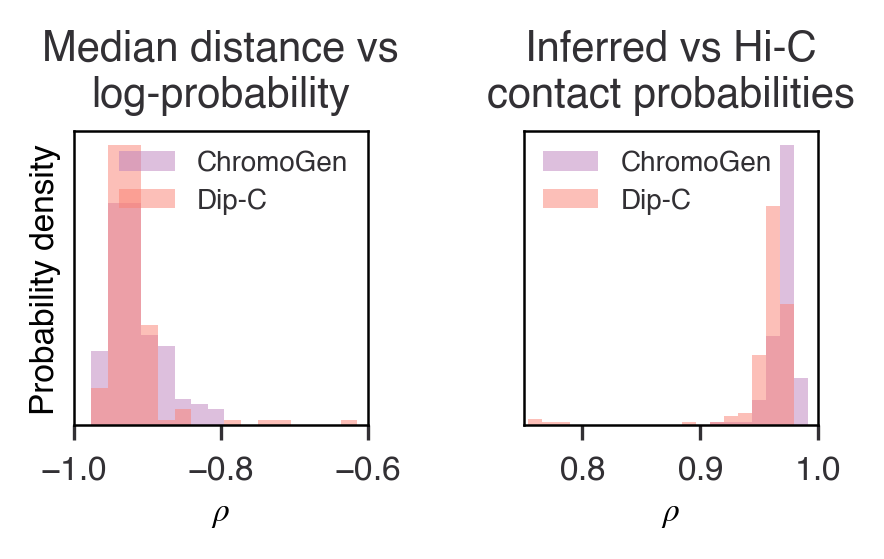

In [10]:
fig,axes = plt.subplots(ncols=2,nrows=1,layout='constrained',figsize=(3,1.75))


###########################
# Median dists vs log probabilities

####
# fetch data from the dictionaries
data1 = torch.tensor(results['GM12878']['ChromoGen']['dist_v_prob_corr'])
data2 = torch.tensor(results['GM12878']['Dip-C']['dist_v_prob_corr'])

# Drop NaN values, which arise in regions with exclusively NaN values in the balanced 
# experimental Hi-C (due to repeats, amplification issues, etc.) 
data1 = data1[data1.isfinite()]
data2 = data2[data2.isfinite()]

# Print the median values
print(f'ChromoGen dist_v_prob median: {data1.median()}')
print(f'Dip-C dist_v_prob median: {data2.median()}')

####
# Plot
ax = axes[0]
#bins = torch.arange(-1,-.599,.4/15)
bins = torch.arange(-0.9756, -0.4105+.0003, (-0.4105+0.9756)/25)
plot_hist(
    data1 = data1,
    data2 = data2,
    tag1 = 'ChromoGen',
    tag2 = 'Dip-C',
    nbins = 13,#13,
    fig = fig,
    ax = ax,
    alpha = 0.5,
    bins = bins
)

####
# Additional formatting
ax.set_ylabel('Probability density')
ax.set_xlabel('$\\rho$')
ax.set_yticks([])
ax.set_xlim([-1,-.6])
ax.set_xticks([-1,-.8,-.6])
ax.set_title('Median distance vs\nlog-probability')
ax.legend(frameon=False,fontsize='small')
xl = ax.get_xlim()
yl = ax.get_ylim()
ax.set_aspect( (xl[1]-xl[0]) / (yl[1]-yl[0]) )

###########################
# ChromoGen vs experimental contact probabilities

####
# fetch data from the dictionaries
data1 = torch.tensor(results['GM12878']['ChromoGen']['prob_v_prob_corr'])
data2 = torch.tensor(results['GM12878']['Dip-C']['prob_v_prob_corr'])

# Drop NaN values, which arise in regions with exclusively NaN values in the balanced 
# experimental Hi-C (due to repeats, amplification issues, etc.) 
data1 = data1[data1.isfinite()]
data2 = data2[data2.isfinite()]

# Print the median values
print(f'ChromoGen prob_v_prob median: {data1.median()}')
print(f'Dip-C prob_v_prob median: {data2.median()}')

####
# Plot
ax = axes[1]
bins = torch.arange(.695, .993, (.992-.695)/25).numpy() 
bins = [0.6945, 0.7064, 0.7183, 0.7302, 0.7421, 0.7540, 0.7659, 0.7778, 0.7897,
         0.8016, 0.8135, 0.8254, 0.8373, 0.8492, 0.8611, 0.8730, 0.8849, 0.8968,
         0.9087, 0.9206, 0.9325, 0.9444, 0.9563, 0.9682, 0.9801, 0.9920]
plot_hist(
    data1 = data1,
    data2 = data2,
    tag1 = 'ChromoGen',
    tag2 = 'Dip-C',
    nbins = 13,#25,
    fig = fig,
    ax = ax,
    alpha = 0.5,
    bins = bins
)

####
# Additional formatting
ax.set_xlabel('$\\rho$')
ax.set_yticks([])
ax.set_xlim([.75,1])
ax.set_xticks([.8,.9,1.])
ax.set_title('Inferred vs Hi-C\ncontact probabilities')
ax.legend(frameon=False,fontsize='small')
xl = ax.get_xlim()
yl = ax.get_ylim()
ax.set_aspect( (xl[1]-xl[0]) / (yl[1]-yl[0]) )

fig.savefig(pdf_dir/'part_a1.pdf',transparent=True)

#### Part A, right panel

Median: 0.901657086032995


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 5 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fontTools.subset:Closing glyph list over 'glyf': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fo

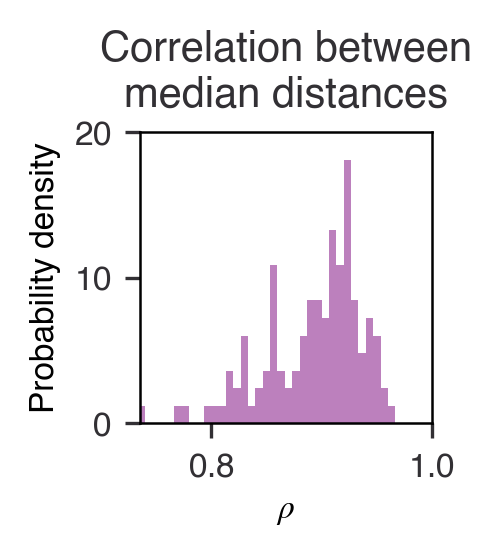

In [11]:
#data1 = torch.tensor(results['GM12878']['dist_vs_dist'])
data1 = torch.tensor([v for v in results['GM12878']['dist_vs_dist'] if v is not None])


print(f'Median: {data1.median()}')

'''
nbins = 100
minn = 0.32
maxx = 0.98
'''
nbins=50
minn = 0.6459
maxx = 0.9804
#minn = float(data1[data1.isfinite()].min())
#maxx = float(data2[data1.isfinite()].max())
delta = (maxx - minn) / nbins
bins = torch.arange(minn,maxx+delta/2,delta)
#bins = torch.arange(.695, .993, (.992-.695)/45).numpy() 


fig,ax = plt.subplots(ncols=1,nrows=1,layout='constrained',figsize=(1.5,1.75))

plot_hist(
    data1,
    None,
    tag1='',
    tag2='',
    nbins=50,
    fig=fig,
    ax=ax,
    alpha=1,
    bins=bins
)

minn = float(data1[data1.isfinite()].min())
ax.set_xlim([minn,1])
xticks = torch.arange(1,minn,-.2).flip(0).tolist()
ax.set_xticks(xticks)
ax.set_ylim([0,20])
yticks = torch.arange(0,21,10).tolist()
ax.set_yticks(yticks)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))

ax.set_ylabel('Probability density')
ax.set_xlabel('$\\rho$')
ax.set_title('Correlation between\nmedian distances')


fig.savefig(pdf_dir / 'part_a2.pdf',transparent=True)

#### Part B

IMR-90 dist_v_prob median: -0.8965969342007037
GM12878 dist_v_prob median: -0.9234035240333365
IMR-90 prob_v_prob median: 0.9663382612169178
GM12878 prob_v_prob median: 0.9737217518520024


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 5 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fontTools.subset:Closing glyph list over 'glyf': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'space', 'uni03C1']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 528]
INFO:fo

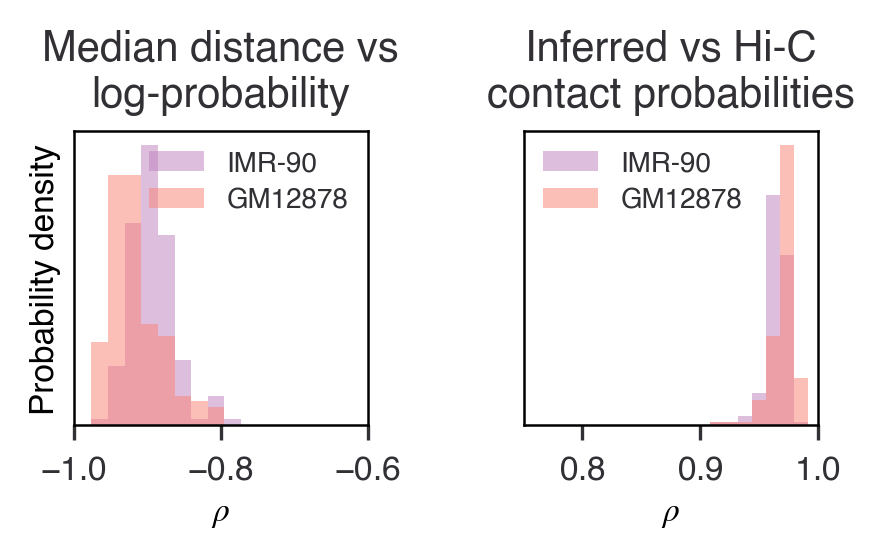

In [12]:
fig,axes = plt.subplots(ncols=2,nrows=1,layout='constrained',figsize=(3,1.75))


###########################
# Median dists vs log probabilities

####
# fetch data from the dictionaries
data1 = torch.tensor(results['IMR-90']['ChromoGen']['dist_v_prob_corr'])
data2 = torch.tensor(results['GM12878']['ChromoGen']['dist_v_prob_corr'])

# Drop NaN values, which arise in regions with exclusively NaN values in the balanced 
# experimental Hi-C (due to repeats, amplification issues, etc.) 
data1 = data1[data1.isfinite()]
data2 = data2[data2.isfinite()]

# Print the median values
print(f'IMR-90 dist_v_prob median: {data1.median()}')
print(f'GM12878 dist_v_prob median: {data2.median()}')

####
# Plot
ax = axes[0]
#bins = torch.arange(-1,-.599,.4/15)
bins = torch.arange(-0.9756, -0.4105+.0003, (-0.4105+0.9756)/25)
plot_hist(
    data1 = data1,
    data2 = data2,
    tag1 = 'IMR-90',
    tag2 = 'GM12878',
    nbins = 13,#13,
    fig = fig,
    ax = ax,
    alpha = 0.5,
    bins = bins
)

####
# Additional formatting
ax.set_ylabel('Probability density')
ax.set_xlabel('$\\rho$')
ax.set_yticks([])
ax.set_xlim([-1,-.6])
ax.set_xticks([-1,-.8,-.6])
ax.set_title('Median distance vs\nlog-probability')
ax.legend(frameon=False,fontsize='small')
xl = ax.get_xlim()
yl = ax.get_ylim()
ax.set_aspect( (xl[1]-xl[0]) / (yl[1]-yl[0]) )

###########################
# ChromoGen vs experimental contact probabilities

####
# fetch data from the dictionaries
data1 = torch.tensor(results['IMR-90']['ChromoGen']['prob_v_prob_corr'])
data2 = torch.tensor(results['GM12878']['ChromoGen']['prob_v_prob_corr'])

# Drop NaN values, which arise in regions with exclusively NaN values in the balanced 
# experimental Hi-C (due to repeats, amplification issues, etc.) 
data1 = data1[data1.isfinite()]
data2 = data2[data2.isfinite()]

# Print the median values
print(f'IMR-90 prob_v_prob median: {data1.median()}')
print(f'GM12878 prob_v_prob median: {data2.median()}')

####
# Plot
ax = axes[1]
bins = torch.arange(.695, .993, (.992-.695)/25).numpy() 
bins = [0.6945, 0.7064, 0.7183, 0.7302, 0.7421, 0.7540, 0.7659, 0.7778, 0.7897,
         0.8016, 0.8135, 0.8254, 0.8373, 0.8492, 0.8611, 0.8730, 0.8849, 0.8968,
         0.9087, 0.9206, 0.9325, 0.9444, 0.9563, 0.9682, 0.9801, 0.9920]
plot_hist(
    data1 = data1,
    data2 = data2,
    tag1 = 'IMR-90',
    tag2 = 'GM12878',
    nbins = 13,#25,
    fig = fig,
    ax = ax,
    alpha = 0.5,
    bins = bins
)

####
# Additional formatting
ax.set_xlabel('$\\rho$')
ax.set_yticks([])
ax.set_xlim([.75,1])
ax.set_xticks([.8,.9,1.])
ax.set_title('Inferred vs Hi-C\ncontact probabilities')
ax.legend(frameon=False,fontsize='small')
xl = ax.get_xlim()
yl = ax.get_ylim()
ax.set_aspect( (xl[1]-xl[0]) / (yl[1]-yl[0]) )

fig.savefig(pdf_dir/'part_b.pdf',transparent=True)    